## bibliotecas e funções

In [1]:
# Manipulação e Tratamento de dados
import openpyxl
import pandas as pd
import numpy as np
from numpy import NaN
import duckdb as dd

#ignorando Warning inuteis
import warnings 
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#definindo quantidade de linhas e colunas visiveis
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)

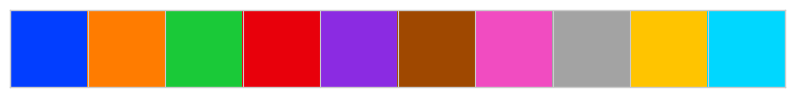

In [2]:
# Graficos ############################
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates

plt.style.use('dark_background')
plt.style.use('seaborn-v0_8-whitegrid')

import seaborn as sns
custom_palette = sns.color_palette("bright")
sns.palplot(custom_palette)
sns.set_palette("bright")
sns.set_style('whitegrid') #cor da grade(fundo)

# Definindo o estilo de fonte e tema
import matplotlib.font_manager as fm #para alterar as fontes dos graficos
fonte = fm.FontProperties(family="Calibri", style="italic")
%matplotlib inline

In [3]:
# Copia e cola
import pyperclip

# Manipulação de Strings
from unidecode import unidecode #unidecode(string)
import re # Regex

# Controle de Erros
import traceback

# Manipualação de datas
from datetime import *

In [4]:
# Carregando minhas funções de analise de dados e criação de modelos
import requests

url = "https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/" + 'funcoes_estatisticas' + ".py"
print(url); response = requests.get(url); code = response.text; exec(code)

# Função para avaliação de modelos exibindo metricas de avaliação
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, RocCurveDisplay
url = "https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/" + 'ML_supervised_learning' + ".py"
print(url); response = requests.get(url); code = response.text; exec(code)

def aval_modelo_corte_tabela(y_true, y_probs_positivas, beta = 1.5, pontos_de_corte = np.arange(10, 100, 10)):
    y_probs_positivas = np.array(y_probs_positivas)
    # Inicializando um DataFrame para armazenar as métricas
    fd = pd.DataFrame(columns=['threshold', 'tn', 'fp', 'fn', 'tp'])

    # Loop pelos pontos de corte
    for threshold in pontos_de_corte:
        previsoes_personalizadas = (y_probs_positivas >= threshold).astype(int)

        # Calculando os valores de tn, fp, fn, tp
        tn = len(np.where((previsoes_personalizadas == 0) & (y_true == 0))[0])
        fp = len(np.where((previsoes_personalizadas == 1) & (y_true == 0))[0])
        
        fn = len(np.where((previsoes_personalizadas == 0) & (y_true == 1))[0])
        tp = len(np.where((previsoes_personalizadas == 1) & (y_true == 1))[0])

        # Adicionando os resultados ao DataFrame 'fd'
        fd = pd.concat([fd, pd.DataFrame([[threshold, tn, fp, fn, tp]], columns=fd.columns)])

    # Substituir valores NaN por 0
    fd.fillna(0, inplace=True)
    fd.reset_index(drop=True, inplace=True)
    ######################################################################################

    # Inicializar as colunas das métricas com NaN
    metricas_de_aval = ['acuracia', 'precisao', 'sensibilidade', 'especificidade', 'f1', #'fb_score',
                        # 'valor_pre_posi', 'valor_pre_neg', 'taxa_falsos_positivos', 'taxa_falsos_negativos',
                        'custo_who','fraude_evitada','fraude_tomada','delta']#,
                        # 'fdr', 'fo_r', 'indice_youden', 'coef_matthews']
    fd[metricas_de_aval] = 0

    # Loop para calcular as métricas em cada linha
    for i in range(len(fd)):
        # Acurácia
        if (fd['tn'][i] + fd['fp'][i] + fd['fn'][i] + fd['tp'][i]) != 0:
            fd['acuracia'][i] = (fd['tp'][i] + fd['tn'][i]) / (fd['tn'][i] + fd['fp'][i] + fd['fn'][i] + fd['tp'][i])

        # Precisão
        if (fd['tp'][i] + fd['fp'][i]) != 0:
            fd['precisao'][i] = fd['tp'][i] / (fd['tp'][i] + fd['fp'][i])

        # Sensibilidade (Recall)
        if (fd['tp'][i] + fd['fn'][i]) != 0:
            fd['sensibilidade'][i] = fd['tp'][i] / (fd['tp'][i] + fd['fn'][i])

        # Especificidade
        if (fd['tn'][i] + fd['fp'][i]) != 0:
            fd['especificidade'][i] = fd['tn'][i] / (fd['tn'][i] + fd['fp'][i])

        # F1-Score
        if (fd['precisao'][i] + fd['sensibilidade'][i]) != 0:
            fd['f1'][i] = 2 * (fd['precisao'][i] * fd['sensibilidade'][i]) / (fd['precisao'][i] + fd['sensibilidade'][i])

        # # Valor Preditivo Positivo
        # if (fd['tp'][i] + fd['fp'][i]) != 0:
        #     fd['valor_pre_posi'][i] = fd['tp'][i] / (fd['tp'][i] + fd['fp'][i])

        # # Valor Preditivo Negativo
        # if (fd['tn'][i] + fd['fn'][i]) != 0:
        #     fd['valor_pre_neg'][i] = fd['tn'][i] / (fd['tn'][i] + fd['fn'][i])

        # # Taxa de Falsos Positivos
        # fd['taxa_falsos_positivos'][i] = 1 - fd['especificidade'][i]

        # # Taxa de Falsos Negativos
        # fd['taxa_falsos_negativos'][i] = 1 - fd['sensibilidade'][i]

        fd['custo_who'][i] = (fd['tp'][i] + fd['fp'][i]) * 10.0
        fd['fraude_evitada'][i] = fd['tp'][i] * 8000
        fd['fraude_tomada'][i] = fd['fn'][i] * 8000
        fd['delta'][i] = fd['fraude_evitada'][i] - fd['custo_who'][i] - fd['fraude_tomada'][i]

        # # False Discovery Rate (FDR)
        # if (fd['tp'][i] + fd['fp'][i]) != 0:
        #     fd['fdr'][i] = fd['fp'][i] / (fd['tp'][i] + fd['fp'][i])

        # # False Omission Rate (FOR)
        # if (fd['tn'][i] + fd['fn'][i]) != 0:
        #     fd['fo_r'][i] = fd['fn'][i] / (fd['tn'][i] + fd['fn'][i])

        # # Índice de Youden
        # fd['indice_youden'][i] = fd['sensibilidade'][i] + fd['especificidade'][i] - 1

        # try:
        #     # Coeficiente de Matthews (MCC)
        #     denom_matthews = (fd['tp'][i]+fd['fp'][i])*(fd['tp'][i]+fd['fn'][i])*(fd['tn'][i]+fd['fp'][i])*(fd['tn'][i]+fd['fn'][i])
        #     if denom_matthews != 0:
        #         fd['coef_matthews'][i] = (fd['tp'][i]*fd['tn'][i] - fd['fp'][i]*fd['fn'][i]) / np.sqrt(denom_matthews)
        # except:
        #     fd['coef_matthews'][i] = np.nan

        # # F-beta Score
        # denom_fb_score = (beta**2 * fd['valor_pre_posi'][i]) + fd['sensibilidade'][i]
        # if denom_fb_score != 0:
        #     fd['fb_score'][i] = (1 + beta**2) * (fd['valor_pre_posi'][i] * fd['sensibilidade'][i]) / denom_fb_score

    fd[metricas_de_aval] = fd[metricas_de_aval].round(5)
    return fd

print('TUDO OK')

https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/funcoes_estatisticas.py
https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/ML_supervised_learning.py
TUDO OK


In [5]:
def tabela_cont(df, linha, coluna):
    a = df.groupby([linha, coluna]).size().unstack()
    for i in a.columns:
        a[i].fillna(0, inplace = True)
        a[i] = a[i].apply(lambda x: int(x))
    return a

def count_table_percent(df, linha, coluna, opcao):
    result = tabela_cont(df, linha, coluna)
    if opcao == 'Linha':
        return round(result.div(result.sum(axis=1), axis=0) * 100, 2)
    elif opcao == 'Coluna':
        return round(result.div(result.sum(), axis=1) * 100, 2)
    else:
        return 'Opção invalida'

In [6]:
from sklearn.ensemble import BaggingClassifier

# Função para plotar a importância das características de um modelo
def feature_importance_emsamble(modelo, x_columns):

    # Função para calcular a importância média das características no BaggingClassifier
    def feature_importance_bagging(modelo, x_columns):
        if hasattr(modelo, 'estimators_'):
            # Verificar se os estimadores possuem feature_importances_
            importancias = [tree.feature_importances_ for tree in modelo.estimators_ if hasattr(tree, 'feature_importances_')]
            if len(importancias) > 0:
                # Calcula a média das importâncias
                media_importancias = np.mean(importancias, axis=0)
                return pd.DataFrame({'colunas': x_columns, 'importancia': media_importancias})

    # Verificar se o modelo possui o atributo feature_importances_
    if hasattr(modelo, 'feature_importances_'):
        importancias = pd.DataFrame({'colunas': x_columns, 
                                     'importancia': modelo.feature_importances_})
    elif isinstance(modelo, BaggingClassifier):
        importancias = feature_importance_bagging(modelo, x_columns)
    else:
        print(f"O modelo não possui feature_importances_.")
        return

    importancias = importancias.sort_values(by='importancia', ascending=False)
    return importancias

def plot_importancias(tabela_feature_importance):
    plt.figure(figsize=(10, 12))
    sns.barplot(x='importancia', y='colunas', data=tabela_feature_importance, palette='viridis')
    # plt.title(f'Importância das Características - {nome_modelo}')
    plt.xlabel('Importância')
    plt.ylabel('Características')
    plt.show()

### carregando dataframe

In [17]:
# df = pd.read_csv('dados_consolidados.csv', sep=';')
df = pd.read_parquet('dados_consolidados_amostra.parquet')
df_bck = df.copy()
print(df.shape)
df.sample(3)

(35332, 86)


,CIDADE_CADASTRO,COD_BENEFICIO,COD_LOJA_ATIVACAO,COD_LOJA_OFICIAL,COD_SIGLA,COD_SOLICBENEFICIO,COD_STATUS,COMPARA_LOJA,COMPARA_LOJA_UF,COMPARA_NASC,DATA_BIOMETRIA,DES_DOCUMENTO,DES_DOCUMENTO_bin,DES_MEIOPAGAMENTO,DES_METODO,DIAS_ATIVACAO,DIAS_ATIVACAO2,DIAS_ATIVACAO2_bin,DIAS_ATIVACAO_bin,DIA_SEMANA,DIA_SEMANA_qtde_fraudes_6meses,DIF_DATA_MIN,DIF_DATA_MIN_bin,DTAHRA_INI_SOLICITACAO,DTA_CONTROLE,DTA_INI_SOLICITACAO,DTA_INI_SOLICITACAO_menos6meses,DTA_NASCIMENTO,DTA_NASCIMENTO_CADUNICO,DTA_NASCIMENTO_CAD_BENE,DTA_VALIDADE_CREDITO,DTH_INCLUSAO,IDADE,IDADE_CAT10_10,IDADE_CAT10_10_qtde_fraudes_6meses,INDEXX,NOME_LOJA_ATIVACAO,NOME_LOJA_OFICIAL,NOM_ESPECIEBENEFICIO,NOM_ESPECIEBENEFICIO2,NOM_ESPECIEBENEFICIO_qtde_fraudes_6meses,NOM_PAPELPESSOA,NUM_BENEFICIO,NUM_CPF,NUM_LOTEPREGAO,PRACA,QTDE_CPFS_COM_MESMO_TELEFONE,QTDE_TELEFONES_COMPARTILHADOS,SCORE_UNICO,SCORE_UNICO_CAT,SCORE_UNICO_CAT_qtde_fraudes_6meses,SEQ_ORGAOPAGADOR,SLG_SEXO,STATUS_WHO,TELEFONE_COMPARTILHADO,TIPO_BENEFICIO,TPO_DOCUMENTO,TPO_DOCUMENTO_bin,UF_CADASTRO,UF_CADASTRO_REGIAO,UF_CADASTRO_REGIAO_qtde_fraudes_6meses,UF_CADASTRO_qtde_fraudes_6meses,UF_LOJA_ATIVACAO,UF_LOJA_ATIVACAO_qtde_fraudes_6meses,UF_LOJA_OFICIAL,VLR_TOTALCREDITO,VLR_TOTALCREDITO_1000em1000,VLR_TOTALCREDITO_500em500,VLR_TOTALCREDITO_bin,Y,beneficio_de_risco,beneficios_que_tiveram_fraude,comparacao_cadastro_unico_e_bene,INI_SOLICITACAO_TRIMESTRE,SCORE_UNICO_CAT_com_fraude_periodo_passado_TRIMESTRE_qtde,SCORE_UNICO_CAT_com_fraude_periodo_passado_TRIMESTRE_bin,IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_qtde,IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_bin,DIA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_qtde,DIA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_bin,UF_CADASTRO_com_fraude_periodo_passado_TRIMESTRE_qtde,UF_CADASTRO_com_fraude_periodo_passado_TRIMESTRE_bin,UF_CADASTRO_REGIAO_com_fraude_periodo_passado_TRIMESTRE_qtde,UF_CADASTRO_REGIAO_com_fraude_periodo_passado_TRIMESTRE_bin,NOM_ESPECIEBENEFICIO_com_fraude_periodo_passado_TRIMESTRE_qtde,NOM_ESPECIEBENEFICIO_com_fraude_periodo_passado_TRIMESTRE_bin
10582,IRARA,2796546,6330,6330,RPA_INSS,3011365,33,1,1,0,2024-04-09,DOCUMENTO DE IDENTIFICACAO,1,CARTAO MAGNETICO,CreateProcess,21.0,7.0,1,1,Tuesday,50,-235.950000,0,09/04/2024 10:49:03,09/04/2024 11:50:15,2024-04-09,2023-10-09,1983-05-16,1983-05-16,1983-05-16,2024-04-02,2024-03-19,40.0,40–49,19,743031,FILIAL SETE DE SETEMBRO BA,FILIAL SETE DE SETEMBRO BA,AUXILIO DOENCA PREVIDENCIARIO (BENEFICIO TEMPO...,AUXILIO DOENCA PREVIDENCIARIO,44,TITULAR,6480946956,04273895501,15,PRACA ANTIGA,3.0,1.0,70.0,Aprovado e Confiavel Unico Check,24,131,0,Não_Analisado,1,0,1,1,BA,Nordeste,52,6,BA,6,BA,870.72,0–999,500–999,0,0,1,1,1,2024Q2,16,1,8,1,21,1,3,1,17,1,18,1
8129,PONTA PORA,3095535,4098,4098,RPA_INSS,3341204,33,1,1,0,2024-08-01,DOCUMENTO DE IDENTIFICACAO,1,CARTAO MAGNETICO,DocumentInsert,17.0,2.0,1,1,Thursday,26,-194.700000,1,01/08/2024 15:26:18,01/08/2024 16:02:39,2024-08-01,2024-02-01,1944-08-17,1944-08-17,1944-08-17,2024-07-30,2024-07-15,79.0,70–79,27,45536,FILIAL DOURADOS MS,FILIAL DOURADOS MS,AMPARO SOCIAL AO IDOSO,LOES,37,TITULAR,5370646143,01721743170,3,PRACA_NAO_LISTADA,1.0,0.0,10.0,Face Nova e Desconhecida,30,395,0,Aprovação,0,1,1,1,MS,Centro-Oeste,4,0,MS,0,MS,13026.00,13000–13999,13000–13499,1,0,1,1,1,2024Q3,15,1,16,1,14,1,0,0,1,1,18,1
12261,SAO JOSE,3013285,2961,2961,RPA_INSS,3235432,33,1,1,0,2024-07-04,DOCUMENTO DE IDENTIFICACAO,1,CARTAO MAGNETICO,CreateProcess,16.0,2.0,1,1,Thursday,25,-208.116667,0,04/07/2024 10:48:53,04/07/2024 11:22:35,2024-07-04,2024-01-04,1962-05-06,1962-05-06,1962-05-06,2024-07-02,2024-06-18,62.0,60–69,48,291919,FILIAL RIO PEQUENO SP,FILIAL RIO PEQUENO SP,APOSENTADORIA POR IDADE,APOSENTADORIA,22,TITULAR,2227447626,31121217400,7,PRACA ANTIGA,1.0,0.0,95.0,Aprovado e Confiavel Unico Check,69,1072,0,Não_Analisado,0,1,1,1,SP,Sudeste,85,30,SP,29,SP,15732.66,15000+,15000+,1,0,1,1,1,2024Q3,45,1,33,1,14,1,15,1,47,1,18,1


In [18]:
df['ANO_MES'] = pd.to_datetime(df['DTA_INI_SOLICITACAO'], errors='coerce')
df['ANO_MES'] = df['ANO_MES'].dt.strftime('%Y%m')
df['ANO_MES'] = df['ANO_MES'].astype(int)

# Aplicando filtros =========================================================
print(df.shape)
# # lista_unico = ['Erro - N Validado','Face Nova e Desconhecida','Reprovado 1:1','Reprovado Unico Check','Sem Biometria']
# # df = df[df['SCORE_UNICO_CAT'].isin(lista_unico)].reset_index(drop=True)
# df = df[df['SCORE_UNICO'] == 0].reset_index(drop=True)

# criterio1 = ~( (df['Y'] == 0) & (df['ANO_MES'] < 202310) )
# criterio2 = ~( (df['Y'] == 0) & (df['ANO_MES'] >= 202503) )
# df = df[criterio1 & criterio2].sort_values(by='DTA_INI_SOLICITACAO').reset_index(drop=True)
print(df.shape)
# ===========================================================================

df = df.sort_values(by='DTA_INI_SOLICITACAO').reset_index(drop=True)
df['INDEXX'] = df.index

df.groupby(['ANO_MES','Y']).size().unstack().fillna(0).round(0)

(35332, 87)
(35332, 87)


Y,0,1
ANO_MES,,
202301,513.0,1.0
202302,421.0,0.0
202303,437.0,0.0
202304,432.0,0.0
202305,643.0,0.0
202306,845.0,0.0
202307,914.0,0.0
202308,1280.0,0.0
202309,1149.0,1.0


In [19]:
tipos_colunas = pd.DataFrame(df.dtypes).reset_index()
display(tipos_colunas)
# tipos_colunas.to_excel('tipo_colunas.xlsx', index=False)

,index,0
0,CIDADE_CADASTRO,object
1,COD_BENEFICIO,object
2,COD_LOJA_ATIVACAO,object
3,COD_LOJA_OFICIAL,object
4,COD_SIGLA,object
...,...,...
82,UF_CADASTRO_REGIAO_com_fraude_periodo_passado_...,int64
83,UF_CADASTRO_REGIAO_com_fraude_periodo_passado_...,int64
84,NOM_ESPECIEBENEFICIO_com_fraude_periodo_passad...,int64
85,NOM_ESPECIEBENEFICIO_com_fraude_periodo_passad...,int64


# =========================================

In [20]:
# df = df_bck.copy()

# excluindo colunas não usadas no modelo

In [21]:
drop_colunas = [
'DTA_CONTROLE',

'DTA_INI_SOLICITACAO','DTAHRA_INI_SOLICITACAO',
'DTA_INI_SOLICITACAO_menos6meses',

'DTH_INCLUSAO',

'DTA_NASCIMENTO',
'COD_BENEFICIO',
'COD_SOLICBENEFICIO',
'NUM_BENEFICIO',
'NUM_CPF',
'DTA_NASCIMENTO_CAD_BENE',

'SEQ_ORGAOPAGADOR',
'NUM_LOTEPREGAO',

'COD_STATUS',
'COMPARA_NASC',

'NOM_ESPECIEBENEFICIO',

'COD_LOJA_ATIVACAO',
'NOME_LOJA_ATIVACAO',

'COD_LOJA_OFICIAL',
'NOME_LOJA_OFICIAL',

'DTA_VALIDADE_CREDITO',

'CIDADE_CADASTRO',
'QTDE_CPFS_COM_MESMO_TELEFONE',
'QTDE_TELEFONES_COMPARTILHADOS',

'DATA_BIOMETRIA',
'DES_METODO',
'COD_SIGLA',
'DTA_NASCIMENTO_CADUNICO',

'DES_DOCUMENTO', 'DES_DOCUMENTO_bin',
'TPO_DOCUMENTO', 'TPO_DOCUMENTO_bin',
'DES_MEIOPAGAMENTO',

'STATUS_WHO',
]
df_colunas_excluidas = df[drop_colunas].copy()
df_colunas_excluidas['INDEXX'] = df['INDEXX']
df = df.drop(drop_colunas, axis=1)

sorted(df.columns)

['ANO_MES',
 'COMPARA_LOJA',
 'COMPARA_LOJA_UF',
 'DIAS_ATIVACAO',
 'DIAS_ATIVACAO2',
 'DIAS_ATIVACAO2_bin',
 'DIAS_ATIVACAO_bin',
 'DIA_SEMANA',
 'DIA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_bin',
 'DIA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_qtde',
 'DIA_SEMANA_qtde_fraudes_6meses',
 'DIF_DATA_MIN',
 'DIF_DATA_MIN_bin',
 'IDADE',
 'IDADE_CAT10_10',
 'IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_bin',
 'IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_qtde',
 'IDADE_CAT10_10_qtde_fraudes_6meses',
 'INDEXX',
 'INI_SOLICITACAO_TRIMESTRE',
 'NOM_ESPECIEBENEFICIO2',
 'NOM_ESPECIEBENEFICIO_com_fraude_periodo_passado_TRIMESTRE_bin',
 'NOM_ESPECIEBENEFICIO_com_fraude_periodo_passado_TRIMESTRE_qtde',
 'NOM_ESPECIEBENEFICIO_qtde_fraudes_6meses',
 'NOM_PAPELPESSOA',
 'PRACA',
 'SCORE_UNICO',
 'SCORE_UNICO_CAT',
 'SCORE_UNICO_CAT_com_fraude_periodo_passado_TRIMESTRE_bin',
 'SCORE_UNICO_CAT_com_fraude_periodo_passado_TRIMESTRE_qtde',
 'SCORE_UNICO_CAT_qtde_fraudes_6meses',
 'SLG

In [22]:
display(df[df['Y'] == 1].isnull().sum().sort_values(ascending=False).reset_index().head(10))

,index,0
0,COMPARA_LOJA,0
1,UF_CADASTRO_qtde_fraudes_6meses,0
2,UF_LOJA_ATIVACAO_qtde_fraudes_6meses,0
3,UF_LOJA_OFICIAL,0
4,VLR_TOTALCREDITO,0
5,VLR_TOTALCREDITO_1000em1000,0
6,VLR_TOTALCREDITO_500em500,0
7,VLR_TOTALCREDITO_bin,0
8,Y,0
9,beneficio_de_risco,0


In [23]:
display(df.isnull().sum().sort_values(ascending=False).reset_index().head(15))
print(df.shape)
print(df['Y'].value_counts())

df = df.dropna()
print(df.shape)
print(df['Y'].value_counts())

df_colunas_excluidas = df_colunas_excluidas.loc[df.index]

,index,0
0,UF_CADASTRO,7
1,UF_CADASTRO_REGIAO,7
2,UF_LOJA_ATIVACAO,3
3,NOM_PAPELPESSOA,1
4,VLR_TOTALCREDITO,1
5,NOM_ESPECIEBENEFICIO2,1
6,UF_LOJA_OFICIAL,1
7,VLR_TOTALCREDITO_500em500,1
8,VLR_TOTALCREDITO_1000em1000,1
9,DIAS_ATIVACAO2,1


(35332, 53)
Y
0    35322
1       10
Name: count, dtype: int64
(35321, 53)
Y
0    35311
1       10
Name: count, dtype: int64


In [24]:
df_bck_sem_colunas_e_linhas_inuteis = df.copy()

# Tratando dados

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# # Variavel Dependente
# y = df[['Y','INDEXX']] # Processar a variável dependente (Y)
# y = y.set_index('INDEXX', drop=False)
# # y = LabelEncoder().fit_transform(y)

# df = df.drop('Y', axis=1)
# y

In [25]:
# from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
OneHotEncoder(handle_unknown='ignore', sparse_output=True)

from pandas.api.types import is_numeric_dtype, is_object_dtype, is_bool_dtype


def tratando_dados(x):

    # 1. Detectar colunas categóricas automaticamente
    colunas_categoricas = x.select_dtypes(include=['object', 'category']).columns.tolist()
    # 2. Filtrar apenas as colunas categóricas com mais de 2 categorias (não binárias)
    colunas_categoricas_nao_binarias = [col for col in colunas_categoricas if x[col].nunique(dropna=False) > 2]

    # 2. Criar transformador
    one_hot = make_column_transformer(
        (OneHotEncoder(drop='if_binary', sparse_output=False), colunas_categoricas_nao_binarias),
        remainder='passthrough'  # mantém as colunas numéricas
    )

    # 3. Aplicar transformação
    x_transformado = one_hot.fit_transform(x)

    # 4. Recuperar os nomes das novas colunas
    nomes_colunas = one_hot.get_feature_names_out()

    # 5. Transformar em DataFrame
    x = pd.DataFrame(x_transformado, columns=nomes_colunas)
    nomes_colunas_limpos = [nome.split('__')[-1] for nome in nomes_colunas]
    x.columns = nomes_colunas_limpos
    # x['Y'] = y

    # 6. Resetar o índice (opcional, se o índice anterior foi perdido)
    # x.reset_index(drop=True, inplace=True)

    # 7. Listar os nomes das colunas finais
    x_columns = x.columns.tolist()

    return x

### separando as variaveis categoricas com varias categorias para tratar com onehot

In [ ]:
# # 1. Detectar colunas categóricas automaticamente
# colunas_categoricas = df.select_dtypes(include=['object', 'category']).columns.tolist()
# # 2. Filtrar apenas as colunas categóricas com mais de 2 categorias (não binárias)
# colunas_categoricas_nao_binarias = [col for col in colunas_categoricas if df[col].nunique(dropna=False) > 2]

# # print(colunas_categoricas_nao_binarias0)
# print(colunas_categoricas_nao_binarias)

# df_cat_tratados = tratando_dados(df[colunas_categoricas_nao_binarias])
# print(sorted(df_cat_tratados.columns))
# display(df_cat_tratados.head(3))

# df_bin_num = df[[col for col in df.columns if col not in colunas_categoricas_nao_binarias]]
# print(sorted(df_bin_num.columns))
# display(df_bin_num.head(3))

#######################################################################################
# colunas = df_bin_num.columns.to_list() + df_cat_tratados.columns.to_list()
# df = pd.DataFrame(np.concatenate((df_bin_num.to_numpy(), df_cat_tratados.to_numpy()), 1), columns=colunas)

In [26]:
df = tratando_dados(df)
df = df[sorted(df.columns)]
df['INDEXX'] = df['INDEXX'].astype('int64')
df = df.set_index('INDEXX', drop=False)
df.sample(3)

,ANO_MES,COMPARA_LOJA,COMPARA_LOJA_UF,DIAS_ATIVACAO,DIAS_ATIVACAO2,DIAS_ATIVACAO2_bin,DIAS_ATIVACAO_bin,DIA_SEMANA_Friday,DIA_SEMANA_Monday,DIA_SEMANA_Saturday,DIA_SEMANA_Thursday,DIA_SEMANA_Tuesday,DIA_SEMANA_Wednesday,DIA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_bin,DIA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_qtde,DIA_SEMANA_qtde_fraudes_6meses,DIF_DATA_MIN,DIF_DATA_MIN_bin,IDADE,IDADE_CAT10_10_0–9,IDADE_CAT10_10_10–19,IDADE_CAT10_10_20–29,IDADE_CAT10_10_30–39,IDADE_CAT10_10_40–49,IDADE_CAT10_10_50–59,IDADE_CAT10_10_60–69,IDADE_CAT10_10_70–79,IDADE_CAT10_10_80–89,IDADE_CAT10_10_90–99,IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_bin,IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_qtde,IDADE_CAT10_10_qtde_fraudes_6meses,INDEXX,INI_SOLICITACAO_TRIMESTRE_2023Q1,INI_SOLICITACAO_TRIMESTRE_2023Q2,INI_SOLICITACAO_TRIMESTRE_2023Q3,INI_SOLICITACAO_TRIMESTRE_2023Q4,INI_SOLICITACAO_TRIMESTRE_2024Q1,INI_SOLICITACAO_TRIMESTRE_2024Q2,INI_SOLICITACAO_TRIMESTRE_2024Q3,INI_SOLICITACAO_TRIMESTRE_2024Q4,INI_SOLICITACAO_TRIMESTRE_2025Q1,INI_SOLICITACAO_TRIMESTRE_2025Q2,NOM_ESPECIEBENEFICIO2_ACIDENTE_TRABALHO,NOM_ESPECIEBENEFICIO2_APOSENTADORIA,NOM_ESPECIEBENEFICIO2_AUXILIO DOENCA PREVIDENCIARIO,NOM_ESPECIEBENEFICIO2_AUXILIO RECLUSAO,NOM_ESPECIEBENEFICIO2_DEFICIENCIA,NOM_ESPECIEBENEFICIO2_LOES,NOM_ESPECIEBENEFICIO2_MATERNIDADE,NOM_ESPECIEBENEFICIO2_OUTROS,NOM_ESPECIEBENEFICIO2_PENSAO,NOM_ESPECIEBENEFICIO2_TRABALHO,NOM_ESPECIEBENEFICIO2_UNIAO,NOM_ESPECIEBENEFICIO_com_fraude_periodo_passado_TRIMESTRE_bin,NOM_ESPECIEBENEFICIO_com_fraude_periodo_passado_TRIMESTRE_qtde,NOM_ESPECIEBENEFICIO_qtde_fraudes_6meses,NOM_PAPELPESSOA_REPRESENTANTE LEGAL,NOM_PAPELPESSOA_TERCEIRO,NOM_PAPELPESSOA_TITULAR,PRACA_PRACA ANTIGA,PRACA_PRACA NOVA,PRACA_PRACA_NAO_LISTADA,SCORE_UNICO,SCORE_UNICO_CAT_Aprovado 1:1,SCORE_UNICO_CAT_Aprovado ID,SCORE_UNICO_CAT_Aprovado Unico Check,SCORE_UNICO_CAT_Aprovado e Confiavel Unico Check,SCORE_UNICO_CAT_Erro - N Validado,SCORE_UNICO_CAT_Face Nova e Desconhecida,SCORE_UNICO_CAT_Reprovado 1:1,SCORE_UNICO_CAT_Reprovado Unico Check,SCORE_UNICO_CAT_Sem Biometria,SCORE_UNICO_CAT_com_fraude_periodo_passado_TRIMESTRE_bin,SCORE_UNICO_CAT_com_fraude_periodo_passado_TRIMESTRE_qtde,SCORE_UNICO_CAT_qtde_fraudes_6meses,SLG_SEXO,TELEFONE_COMPARTILHADO,TIPO_BENEFICIO,UF_CADASTRO_AC,UF_CADASTRO_AL,UF_CADASTRO_AM,UF_CADASTRO_AP,UF_CADASTRO_BA,UF_CADASTRO_CE,UF_CADASTRO_DF,UF_CADASTRO_ES,UF_CADASTRO_GO,UF_CADASTRO_MA,UF_CADASTRO_MG,UF_CADASTRO_MS,UF_CADASTRO_MT,UF_CADASTRO_PA,UF_CADASTRO_PB,UF_CADASTRO_PE,UF_CADASTRO_PI,UF_CADASTRO_PR,UF_CADASTRO_REGIAO_Centro-Oeste,UF_CADASTRO_REGIAO_Nordeste,UF_CADASTRO_REGIAO_Norte,UF_CADASTRO_REGIAO_Sudeste,UF_CADASTRO_REGIAO_Sul,UF_CADASTRO_REGIAO_com_fraude_periodo_passado_TRIMESTRE_bin,UF_CADASTRO_REGIAO_com_fraude_periodo_passado_TRIMESTRE_qtde,UF_CADASTRO_REGIAO_qtde_fraudes_6meses,UF_CADASTRO_RJ,UF_CADASTRO_RN,UF_CADASTRO_RO,UF_CADASTRO_RR,UF_CADASTRO_RS,UF_CADASTRO_SC,UF_CADASTRO_SE,UF_CADASTRO_SP,UF_CADASTRO_TO,UF_CADASTRO_com_fraude_periodo_passado_TRIMESTRE_bin,UF_CADASTRO_com_fraude_periodo_passado_TRIMESTRE_qtde,UF_CADASTRO_qtde_fraudes_6meses,UF_LOJA_ATIVACAO_AC,UF_LOJA_ATIVACAO_AL,UF_LOJA_ATIVACAO_AM,UF_LOJA_ATIVACAO_AP,UF_LOJA_ATIVACAO_BA,UF_LOJA_ATIVACAO_CE,UF_LOJA_ATIVACAO_DF,UF_LOJA_ATIVACAO_ES,UF_LOJA_ATIVACAO_GO,UF_LOJA_ATIVACAO_MA,UF_LOJA_ATIVACAO_MG,UF_LOJA_ATIVACAO_MS,UF_LOJA_ATIVACAO_MT,UF_LOJA_ATIVACAO_PA,UF_LOJA_ATIVACAO_PB,UF_LOJA_ATIVACAO_PE,UF_LOJA_ATIVACAO_PI,UF_LOJA_ATIVACAO_PR,UF_LOJA_ATIVACAO_RJ,UF_LOJA_ATIVACAO_RN,UF_LOJA_ATIVACAO_RO,UF_LOJA_ATIVACAO_RR,UF_LOJA_ATIVACAO_RS,UF_LOJA_ATIVACAO_SC,UF_LOJA_ATIVACAO_SE,UF_LOJA_ATIVACAO_SP,UF_LOJA_ATIVACAO_TO,UF_LOJA_ATIVACAO_qtde_fraudes_6meses,UF_LOJA_OFICIAL_AC,UF_LOJA_OFICIAL_AL,UF_LOJA_OFICIAL_AM,UF_LOJA_OFICIAL_AP,UF_LOJA_OFICIAL_BA,UF_LOJA_OFICIAL_CE,UF_LOJA_OFICIAL_DF,UF_LOJA_OFICIAL_ES,UF_LOJA_OFICIAL_GO,UF_LOJA_OFICIAL_MA,UF_LOJA_OFICIAL_MG,UF_LOJA_OFICIAL_MS,UF_LOJA_OFICIAL_MT,UF_LOJA_OFICIAL_PA,UF_LOJA_OFICIAL_P

In [27]:
tipos_colunas = pd.DataFrame(df.dtypes).reset_index()
display(tipos_colunas)
# tipos_colunas.to_excel('tipo_colunas.xlsx', index=False)

,index,0
0,ANO_MES,object
1,COMPARA_LOJA,object
2,COMPARA_LOJA_UF,object
3,DIAS_ATIVACAO,object
4,DIAS_ATIVACAO2,object
...,...,...
218,VLR_TOTALCREDITO_bin,object
219,Y,object
220,beneficio_de_risco,object
221,beneficios_que_tiveram_fraude,object


In [28]:
for i in range(3, len(df.columns), 3):
    print(sorted(df.columns)[i-3:i])

['ANO_MES', 'COMPARA_LOJA', 'COMPARA_LOJA_UF']
['DIAS_ATIVACAO', 'DIAS_ATIVACAO2', 'DIAS_ATIVACAO2_bin']
['DIAS_ATIVACAO_bin', 'DIA_SEMANA_Friday', 'DIA_SEMANA_Monday']
['DIA_SEMANA_Saturday', 'DIA_SEMANA_Thursday', 'DIA_SEMANA_Tuesday']
['DIA_SEMANA_Wednesday', 'DIA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_bin', 'DIA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_qtde']
['DIA_SEMANA_qtde_fraudes_6meses', 'DIF_DATA_MIN', 'DIF_DATA_MIN_bin']
['IDADE', 'IDADE_CAT10_10_0–9', 'IDADE_CAT10_10_10–19']
['IDADE_CAT10_10_20–29', 'IDADE_CAT10_10_30–39', 'IDADE_CAT10_10_40–49']
['IDADE_CAT10_10_50–59', 'IDADE_CAT10_10_60–69', 'IDADE_CAT10_10_70–79']
['IDADE_CAT10_10_80–89', 'IDADE_CAT10_10_90–99', 'IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_bin']
['IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_qtde', 'IDADE_CAT10_10_qtde_fraudes_6meses', 'INDEXX']
['INI_SOLICITACAO_TRIMESTRE_2023Q1', 'INI_SOLICITACAO_TRIMESTRE_2023Q2', 'INI_SOLICITACAO_TRIMESTRE_2023Q3']
['INI_SOLICITACAO_TRIMESTRE

In [29]:
for col in df.columns:
    qtde_levels = len(df[col].unique())
    if qtde_levels == 2:
        df[col] = df[col].astype(int)
        print(col, '->', 'int')
    else:
        try:
            df[col] = df[col].astype(float)
            print(col, '->', 'float')
        except:
            print(f"Não foi possível converter a coluna '{col}' para float.")

ANO_MES -> float
COMPARA_LOJA -> int
COMPARA_LOJA_UF -> int
DIAS_ATIVACAO -> float
DIAS_ATIVACAO2 -> float
DIAS_ATIVACAO2_bin -> int
DIAS_ATIVACAO_bin -> int
DIA_SEMANA_Friday -> int
DIA_SEMANA_Monday -> int
DIA_SEMANA_Saturday -> int
DIA_SEMANA_Thursday -> int
DIA_SEMANA_Tuesday -> int
DIA_SEMANA_Wednesday -> int
DIA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_bin -> int
DIA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_qtde -> float
DIA_SEMANA_qtde_fraudes_6meses -> float
DIF_DATA_MIN -> float
DIF_DATA_MIN_bin -> int
IDADE -> float
IDADE_CAT10_10_0–9 -> int
IDADE_CAT10_10_10–19 -> int
IDADE_CAT10_10_20–29 -> int
IDADE_CAT10_10_30–39 -> int
IDADE_CAT10_10_40–49 -> int
IDADE_CAT10_10_50–59 -> int
IDADE_CAT10_10_60–69 -> int
IDADE_CAT10_10_70–79 -> int
IDADE_CAT10_10_80–89 -> int
IDADE_CAT10_10_90–99 -> int
IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_bin -> int
IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_qtde -> float
IDADE_CAT10_10_qtde_fraudes_6meses -> float
INDEXX -> f

In [30]:
# df = pd.read_parquet('x_tratados_bck.parquet')
#df.to_parquet('x_tratados_bck_score0.parquet')

In [31]:
for i in sorted(df.columns):
    print(i)

ANO_MES
COMPARA_LOJA
COMPARA_LOJA_UF
DIAS_ATIVACAO
DIAS_ATIVACAO2
DIAS_ATIVACAO2_bin
DIAS_ATIVACAO_bin
DIA_SEMANA_Friday
DIA_SEMANA_Monday
DIA_SEMANA_Saturday
DIA_SEMANA_Thursday
DIA_SEMANA_Tuesday
DIA_SEMANA_Wednesday
DIA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_bin
DIA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_qtde
DIA_SEMANA_qtde_fraudes_6meses
DIF_DATA_MIN
DIF_DATA_MIN_bin
IDADE
IDADE_CAT10_10_0–9
IDADE_CAT10_10_10–19
IDADE_CAT10_10_20–29
IDADE_CAT10_10_30–39
IDADE_CAT10_10_40–49
IDADE_CAT10_10_50–59
IDADE_CAT10_10_60–69
IDADE_CAT10_10_70–79
IDADE_CAT10_10_80–89
IDADE_CAT10_10_90–99
IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_bin
IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_qtde
IDADE_CAT10_10_qtde_fraudes_6meses
INDEXX
INI_SOLICITACAO_TRIMESTRE_2023Q1
INI_SOLICITACAO_TRIMESTRE_2023Q2
INI_SOLICITACAO_TRIMESTRE_2023Q3
INI_SOLICITACAO_TRIMESTRE_2023Q4
INI_SOLICITACAO_TRIMESTRE_2024Q1
INI_SOLICITACAO_TRIMESTRE_2024Q2
INI_SOLICITACAO_TRIMESTRE_2024Q3
INI_SOLICITACAO

In [32]:
df.rename({
    'DIA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_bin': 'D_IA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_bin',
    'DIA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_qtde': 'D_IA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_qtde',
    'DIA_SEMANA_qtde_fraudes_6meses': 'D_IA_SEMANA_qtde_fraudes_6meses',

    'IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_bin': 'I_DADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_bin',
    'IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_qtde': 'I_DADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_qtde',
    'IDADE_CAT10_10_qtde_fraudes_6meses': 'I_DADE_CAT10_10_qtde_fraudes_6meses',

    'NOM_ESPECIEBENEFICIO_com_fraude_periodo_passado_TRIMESTRE_bin': 'N_OM_ESPECIEBENEFICIO_com_fraude_periodo_passado_TRIMESTRE_bin',
    'NOM_ESPECIEBENEFICIO_com_fraude_periodo_passado_TRIMESTRE_qtde': 'N_OM_ESPECIEBENEFICIO_com_fraude_periodo_passado_TRIMESTRE_qtde',
    'NOM_ESPECIEBENEFICIO_qtde_fraudes_6meses': 'N_OM_ESPECIEBENEFICIO_qtde_fraudes_6meses',

    'SCORE_UNICO_CAT_com_fraude_periodo_passado_TRIMESTRE_bin': 'S_CORE_UNICO_CAT_com_fraude_periodo_passado_TRIMESTRE_bin',
    'SCORE_UNICO_CAT_com_fraude_periodo_passado_TRIMESTRE_qtde': 'S_CORE_UNICO_CAT_com_fraude_periodo_passado_TRIMESTRE_qtde',
    'SCORE_UNICO_CAT_qtde_fraudes_6meses': 'S_CORE_UNICO_CAT_qtde_fraudes_6meses',

    'UF_CADASTRO_REGIAO_com_fraude_periodo_passado_TRIMESTRE_bin': 'U_F_CADASTRO_REGIAO_com_fraude_periodo_passado_TRIMESTRE_bin',
    'UF_CADASTRO_REGIAO_com_fraude_periodo_passado_TRIMESTRE_qtde': 'U_F_CADASTRO_REGIAO_com_fraude_periodo_passado_TRIMESTRE_qtde',
    'UF_CADASTRO_REGIAO_qtde_fraudes_6meses': 'U_F_CADASTRO_REGIAO_qtde_fraudes_6meses',

    'UF_CADASTRO_com_fraude_periodo_passado_TRIMESTRE_bin': 'U_F_CADASTRO_com_fraude_periodo_passado_TRIMESTRE_bin',
    'UF_CADASTRO_com_fraude_periodo_passado_TRIMESTRE_qtde': 'U_F_CADASTRO_com_fraude_periodo_passado_TRIMESTRE_qtde',
    'UF_CADASTRO_qtde_fraudes_6meses': 'U_F_CADASTRO_qtde_fraudes_6meses'
}, axis=1, inplace=True)

In [33]:
df_colunas_excluidas['INDEXX'] = df_colunas_excluidas['INDEXX'].astype('int64')
df_colunas_excluidas = df_colunas_excluidas.set_index('INDEXX', drop=False)

#### capturando nomes das colunas

In [34]:
x_colunas_bck = df.columns

#### separando dados

In [35]:
all(df.index == df_colunas_excluidas.index)

True

In [37]:
############################################################################################
# DIVIDINDO BASE EM TREINO E TESTE

from sklearn.model_selection import train_test_split
# train_test_split
grandom_state = 31415922     
x_treino_bck, x_teste_bck, y_treino_bck, y_teste_bck = train_test_split(df, df['Y'], 
                                                        stratify = df['Y'], #para manter a proporção da Var Dep nos splits
                                                        random_state = grandom_state) #raiz da aleatoridade
# -----------------------------------------------------------------------------------------
### DIVIDINDO BASE EM TREINO E TESTE NO ESTILO LINHA TEMPORAL

# data_filtro = '2025-02-01'

# # dados de treino
# index_treino = df_colunas_excluidas[df_colunas_excluidas['DTA_INI_SOLICITACAO'] <= data_filtro].index
# x_treino_bck = df.loc[index_treino]
# y_treino_bck = df.loc[index_treino, 'Y']

# # dados de teste
# index_teste = df_colunas_excluidas[df_colunas_excluidas['DTA_INI_SOLICITACAO'] > data_filtro].index
# x_teste_bck = df.loc[index_teste]
# y_teste_bck = df.loc[index_teste, 'Y']
# -------------------------------------------------------------------------------------------------

# df_filter = df[df['SCORE_UNICO'] == 0]
# print(df_filter.shape)

# valor_quartilico_slice = df.index[int(len(df_filter.index)*95/100)]
# print('data slice (', valor_quartilico_slice, '):', df_colunas_excluidas.loc[valor_quartilico_slice, 'DTA_INI_SOLICITACAO'])

# # dados de treino
# x_treino_bck = df_filter.loc[:valor_quartilico_slice]
# y_treino_bck = df_filter.loc[:valor_quartilico_slice, 'Y']

# # dados de teste
# x_teste_bck = df_filter.loc[valor_quartilico_slice+1:]
# y_teste_bck = df_filter.loc[valor_quartilico_slice+1:, 'Y']
# -------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------

x_treino_bck = pd.DataFrame(x_treino_bck, columns= x_colunas_bck)
x_teste_bck = pd.DataFrame(x_teste_bck, columns= x_colunas_bck)

print(x_treino_bck.shape, x_teste_bck.shape)
print(y_treino_bck.shape, y_teste_bck.shape)

display(pd.concat([x_treino_bck['Y'].value_counts(), x_treino_bck['Y'].value_counts(normalize=True)*100], axis=1))
display(pd.concat([x_teste_bck['Y'].value_counts(), x_teste_bck['Y'].value_counts(normalize=True)*100], axis=1))

(26490, 223) (8831, 223)
(26490,) (8831,)


,count,proportion
Y,,
0,26483,99.973575
1,7,0.026425


,count,proportion
Y,,
0,8828,99.966029
1,3,0.033971


In [38]:
# Contagem dos valores e ordenação
contagem = df['ANO_MES'].value_counts().sort_index()

# Criando uma coluna com a soma acumulada
contagem_acumulada = contagem.cumsum()

pd.concat([contagem, contagem_acumulada], axis=1)


,count,count
ANO_MES,,
202301.0,514,514
202302.0,420,934
202303.0,437,1371
202304.0,431,1802
202305.0,642,2444
202306.0,844,3288
202307.0,913,4201
202308.0,1280,5481
202309.0,1150,6631


In [ ]:
df_bck.groupby(['SCORE_UNICO_CAT'])['SCORE_UNICO'].describe()

# Criando Modelos

In [39]:
from xgboost import XGBClassifier
import joblib  # Para salvar e carregar o pipeline

grandom_state = 3141592

In [40]:
import optuna
from sklearn.metrics import fbeta_score
 
def objective(trial):
    # Sugerindo um número de estimadores entre 10 e 100
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 3000)
    }
 
    # Criando uma nova instância do modelo com os parâmetros sugeridos
    modelo = XGBClassifier(**params, random_state=grandom_state, n_jobs=-1)
    modelo.fit(x_treino, y_treino_bck)  # Certifique-se de que x_treino e y_treino estão definidos
 
    # Fazendo previsões # predictions = modelo.predict(x_teste) # metrica = fbeta_score(y_pred=predictions, y_true=y_teste, beta=1.5)
    y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
    tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
    metrica = tabela['delta'].max() # fb_score
    return metrica
 
############################################################################################
# # Criação do estudo para maximizar a metrica de avaliação do modelo
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10)

# # Melhor resultado
# print('Número do melhor trial:', study.best_trial.number)
# print('Melhores hiperparâmetros:', study.best_trial.params)
# print('Melhor valor da metrica de avaliação usada:', study.best_trial.value)

# # Recriando modelo 
# modelo = XGBClassifier(**study.best_trial.params, random_state=grandom_state, n_jobs=-1)
# modelo.fit(x_treino, y_treino_bck)
# # joblib.dump(modelo, 'modelo_otimizado.pkl') # Salvar modelo com joblib

In [41]:
colunas_escolhidas = [
    'COMPARA_LOJA', 'COMPARA_LOJA_UF',
    'DIAS_ATIVACAO', 'DIAS_ATIVACAO2',
    'DIF_DATA_MIN', 
    
    'NOM_ESPECIEBENEFICIO2', 

    'IDADE',
    'TIPO_BENEFICIO'
    ]

def x_selecionando_colunas(x_tratados_bck, colunas_escolhidas):
    lista_colunas = []
    colunas_escolhidas = sorted(colunas_escolhidas)

    for coluna_escolhida in colunas_escolhidas:

        count = 0
        for coluna in x_tratados_bck.columns:

            if count > 0:
                pass
            elif coluna_escolhida == coluna:
                lista_colunas.append(coluna)
                count += 1
            elif coluna_escolhida in coluna:
                lista_colunas.append(coluna)

    lista_colunas = list(dict.fromkeys(lista_colunas))
    return lista_colunas

x_selecionando_colunas(x_treino_bck, colunas_escolhidas)

['COMPARA_LOJA',
 'COMPARA_LOJA_UF',
 'DIAS_ATIVACAO',
 'DIAS_ATIVACAO2',
 'DIF_DATA_MIN',
 'IDADE',
 'NOM_ESPECIEBENEFICIO2_ACIDENTE_TRABALHO',
 'NOM_ESPECIEBENEFICIO2_APOSENTADORIA',
 'NOM_ESPECIEBENEFICIO2_AUXILIO DOENCA PREVIDENCIARIO',
 'NOM_ESPECIEBENEFICIO2_AUXILIO RECLUSAO',
 'NOM_ESPECIEBENEFICIO2_DEFICIENCIA',
 'NOM_ESPECIEBENEFICIO2_LOES',
 'NOM_ESPECIEBENEFICIO2_MATERNIDADE',
 'NOM_ESPECIEBENEFICIO2_OUTROS',
 'NOM_ESPECIEBENEFICIO2_PENSAO',
 'NOM_ESPECIEBENEFICIO2_TRABALHO',
 'NOM_ESPECIEBENEFICIO2_UNIAO',
 'TIPO_BENEFICIO']

In [42]:
colunas_escolhidas = [
    'COMPARA_LOJA', 'COMPARA_LOJA_UF',
    'DIAS_ATIVACAO', 'DIAS_ATIVACAO2',
    'DIF_DATA_MIN', 'DIF_DATA_MIN_bin', 

    'IDADE',

    'IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_1_qtde',
    'NOM_ESPECIEBENEFICIO_com_fraude_periodo_passado_TRIMESTRE_1_qtde',

    'NOM_PAPELPESSOA',
    'PRACA',
    
    # 'SCORE_UNICO', 'SCORE_UNICO_CAT',
    'SLG_SEXO',
    
    'TELEFONE_COMPARTILHADO',
    'TIPO_BENEFICIO'
    ]
# x_selecionando_colunas(x_treino_bck, colunas_escolhidas)

for coluna in sorted(df.columns):
    print("'"+coluna+"'")

'ANO_MES'
'COMPARA_LOJA'
'COMPARA_LOJA_UF'
'DIAS_ATIVACAO'
'DIAS_ATIVACAO2'
'DIAS_ATIVACAO2_bin'
'DIAS_ATIVACAO_bin'
'DIA_SEMANA_Friday'
'DIA_SEMANA_Monday'
'DIA_SEMANA_Saturday'
'DIA_SEMANA_Thursday'
'DIA_SEMANA_Tuesday'
'DIA_SEMANA_Wednesday'
'DIF_DATA_MIN'
'DIF_DATA_MIN_bin'
'D_IA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_bin'
'D_IA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_qtde'
'D_IA_SEMANA_qtde_fraudes_6meses'
'IDADE'
'IDADE_CAT10_10_0–9'
'IDADE_CAT10_10_10–19'
'IDADE_CAT10_10_20–29'
'IDADE_CAT10_10_30–39'
'IDADE_CAT10_10_40–49'
'IDADE_CAT10_10_50–59'
'IDADE_CAT10_10_60–69'
'IDADE_CAT10_10_70–79'
'IDADE_CAT10_10_80–89'
'IDADE_CAT10_10_90–99'
'INDEXX'
'INI_SOLICITACAO_TRIMESTRE_2023Q1'
'INI_SOLICITACAO_TRIMESTRE_2023Q2'
'INI_SOLICITACAO_TRIMESTRE_2023Q3'
'INI_SOLICITACAO_TRIMESTRE_2023Q4'
'INI_SOLICITACAO_TRIMESTRE_2024Q1'
'INI_SOLICITACAO_TRIMESTRE_2024Q2'
'INI_SOLICITACAO_TRIMESTRE_2024Q3'
'INI_SOLICITACAO_TRIMESTRE_2024Q4'
'INI_SOLICITACAO_TRIMESTRE_2025Q1'
'INI_SOLICITACAO

# ================================================================

# modelo com variaveis simples

[I 2025-05-03 23:04:18,661] A new study created in memory with name: no-name-6c52bde2-7468-4dbc-8f29-c0073bf38f57
[I 2025-05-03 23:04:22,268] Trial 0 finished with value: -24020.0 and parameters: {'learning_rate': 0.061733934295465344, 'n_estimators': 2452}. Best is trial 0 with value: -24020.0.
[I 2025-05-03 23:04:24,974] Trial 1 finished with value: -24020.0 and parameters: {'learning_rate': 0.29099732045024257, 'n_estimators': 2344}. Best is trial 0 with value: -24020.0.
[I 2025-05-03 23:04:25,432] Trial 2 finished with value: -24040.0 and parameters: {'learning_rate': 0.12881742245077116, 'n_estimators': 228}. Best is trial 0 with value: -24020.0.
[I 2025-05-03 23:04:27,593] Trial 3 finished with value: -24060.0 and parameters: {'learning_rate': 0.0011725145508119077, 'n_estimators': 2198}. Best is trial 0 with value: -24020.0.
[I 2025-05-03 23:04:30,905] Trial 4 finished with value: -24020.0 and parameters: {'learning_rate': 0.126410910270136, 'n_estimators': 1940}. Best is trial 

Número do melhor trial: 11
Melhores hiperparâmetros: {'learning_rate': 0.23397760423850678, 'n_estimators': 2587}
Melhor valor da metrica de avaliação usada: -24010.0
DELTA: -24010


,threshold,tn,fp,fn,tp,acuracia,precisao,sensibilidade,especificidade,f1,custo_who,fraude_evitada,fraude_tomada,delta
0,0.00,0,8828,0,3,0.00034,0.00034,1,0.00000,0.00068,88310,24000,0,-64310
1,0.25,8812,16,3,0,0.99785,0.00000,0,0.99819,0.00000,160,0,24000,-24160
2,0.50,8818,10,3,0,0.99853,0.00000,0,0.99887,0.00000,100,0,24000,-24100
3,0.75,8821,7,3,0,0.99887,0.00000,0,0.99921,0.00000,70,0,24000,-24070
4,1.00,8824,4,3,0,0.99921,0.00000,0,0.99955,0.00000,40,0,24000,-24040
5,1.25,8825,3,3,0,0.99932,0.00000,0,0.99966,0.00000,30,0,24000,-24030
6,1.50,8825,3,3,0,0.99932,0.00000,0,0.99966,0.00000,30,0,24000,-24030
7,1.75,8825,3,3,0,0.99932,0.00000,0,0.99966,0.00000,30,0,24000,-24030
8,2.00,8825,3,3,0,0.99932,0.00000,0,0.99966,0.00000,30,0,24000,-24030
9,2.25,8825,3,3,0,0.99932,0.00000,0,0.99966,0.00000,30,0,24000,-24030


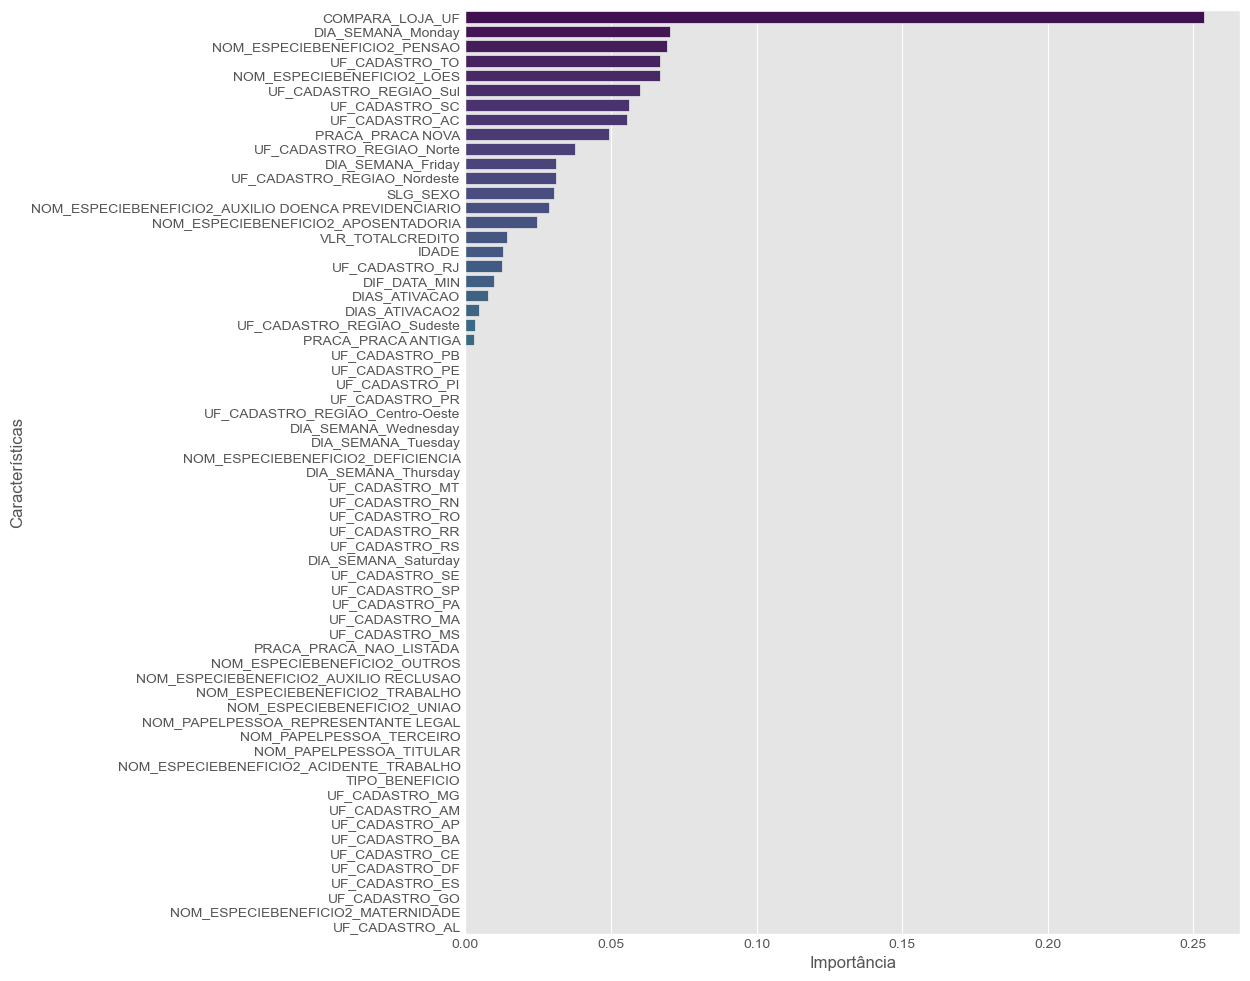

STATUS_WHO  Aprovação  Não_Analisado  Pendência  Reprovação
Y   pred                                                   
0.0 0.0           188           8615          9           0
    1.0             0             16          0           0
1.0 0.0             0              0          0           3

In [43]:
colunas_escolhidas = [
    'COMPARA_LOJA_UF',

    'DIAS_ATIVACAO',
    'DIAS_ATIVACAO2',

    'DIA_SEMANA',

    'DIF_DATA_MIN',

    'IDADE',

    'NOM_ESPECIEBENEFICIO2',

    'NOM_PAPELPESSOA',

    'PRACA',

    'SLG_SEXO',

    'TIPO_BENEFICIO',

    'UF_CADASTRO',
    # 'UF_CADASTRO_REGIAO',

    # 'UF_LOJA_ATIVACAO',
    # 'UF_LOJA_ATIVACAO_qtde_fraudes_6meses',
    # 'UF_LOJA_OFICIAL',

    'VLR_TOTALCREDITO',
    # 'VLR_TOTALCREDITO_1000em1000'
    ]
############################################################################################
x_treino = x_treino_bck.loc[:, x_selecionando_colunas(x_treino_bck, colunas_escolhidas)]
x_teste = x_teste_bck.loc[:, x_selecionando_colunas(x_teste_bck, colunas_escolhidas)]

x_colunas = x_treino.columns.to_list()
x_treino = x_treino.to_numpy()
x_teste = x_teste.to_numpy()

############################################################################################
def objective(trial):
    # Sugerindo um número de estimadores entre 10 e 100
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 3000)
    }
 
    # Criando uma nova instância do modelo com os parâmetros sugeridos
    modelo = XGBClassifier(**params, random_state=grandom_state, n_jobs=-1)
    modelo.fit(x_treino, y_treino_bck)  # Certifique-se de que x_treino e y_treino estão definidos
 
    # Fazendo previsões # predictions = modelo.predict(x_teste) # metrica = fbeta_score(y_pred=predictions, y_true=y_teste, beta=1.5)
    y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
    tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
    metrica = tabela['delta'].max() # fb_score
    return metrica

# # Criação do estudo para maximizar a metrica de avaliação do modelo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Melhor resultado
print('Número do melhor trial:', study.best_trial.number)
print('Melhores hiperparâmetros:', study.best_trial.params)
print('Melhor valor da metrica de avaliação usada:', study.best_trial.value)

# Recriando modelo 
modelo = XGBClassifier(**study.best_trial.params, random_state=grandom_state, n_jobs=-1)
modelo.fit(x_treino, y_treino_bck)
# joblib.dump(modelo, 'modelo_otimizado.pkl') # Salvar modelo com joblib

############################################################################################
y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
print('DELTA:', tabela['delta'].max())
display(tabela)

tabela_feat = feature_importance_emsamble(modelo, x_colunas )
plot_importancias(tabela_feat)

############################################################
df_colunas_excluidas.loc[x_teste_bck.index, 'Y'] = y_teste_bck
df_colunas_excluidas.loc[x_teste_bck.index, 'pred'] = np.where(y_probs_positivas >= 0.25, 1, 0)
df_colunas_excluidas.groupby(['Y','pred','STATUS_WHO']).size().unstack().fillna(0).astype(int)

# modelo com todas todas variaveis

In [ ]:
colunas_escolhidas = [
    'COMPARA_LOJA',
    'COMPARA_LOJA_UF',

    'DIAS_ATIVACAO',
    'DIAS_ATIVACAO2',
    # 'DIAS_ATIVACAO2_bin'
    # 'DIAS_ATIVACAO_bin',

    'DIA_SEMANA',
    'DIA_SEMANA_qtde_fraudes_6meses',

    'DIF_DATA_MIN',
    'DIF_DATA_MIN_bin',

    'IDADE',
    'IDADE_CAT10_10',
    'IDADE_CAT10_10_qtde_fraudes_6meses',

    # 'INDEXX',
    'NOM_ESPECIEBENEFICIO2',
    'NOM_ESPECIEBENEFICIO_qtde_fraudes_6meses',
    'beneficio_de_risco',
    # 'beneficios_que_tiveram_fraude',

    'NOM_PAPELPESSOA',

    'PRACA',

    # 'SCORE_UNICO',
    # 'SCORE_UNICO_CAT',
    # 'SCORE_UNICO_CAT_qtde_fraudes_6meses',

    'SLG_SEXO',

    # 'TELEFONE_COMPARTILHADO',

    'TIPO_BENEFICIO',

    #'UF_CADASTRO',

    'UF_CADASTRO_REGIAO',
    'UF_CADASTRO_REGIAO_qtde_fraudes_6meses',
    'UF_CADASTRO_qtde_fraudes_6meses',

    # 'UF_LOJA_ATIVACAO',
    # 'UF_LOJA_ATIVACAO_qtde_fraudes_6meses',
    # 'UF_LOJA_OFICIAL',

    'VLR_TOTALCREDITO',
    'VLR_TOTALCREDITO_1000em1000'#,
    #'VLR_TOTALCREDITO_500em500',
    #'VLR_TOTALCREDITO_bin',#

    # 'comparacao_cadastro_unico_e_bene'
    ]
############################################################################################
x_treino = x_treino_bck.loc[:, x_selecionando_colunas(x_treino_bck, colunas_escolhidas)]
x_teste = x_teste_bck.loc[:, x_selecionando_colunas(x_teste_bck, colunas_escolhidas)]
x_colunas = x_treino.columns.to_list()
x_treino = x_treino.to_numpy()
x_teste = x_teste.to_numpy()

############################################################################################
def objective(trial):
    # Sugerindo um número de estimadores entre 10 e 100
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 3000)
    }
 
    # Criando uma nova instância do modelo com os parâmetros sugeridos
    modelo = XGBClassifier(**params, random_state=grandom_state, n_jobs=-1)
    modelo.fit(x_treino, y_treino_bck)  # Certifique-se de que x_treino e y_treino estão definidos
 
    # Fazendo previsões # predictions = modelo.predict(x_teste) # metrica = fbeta_score(y_pred=predictions, y_true=y_teste, beta=1.5)
    y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
    tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
    metrica = tabela['delta'].max() # fb_score
    return metrica

# # Criação do estudo para maximizar a metrica de avaliação do modelo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Melhor resultado
print('Número do melhor trial:', study.best_trial.number)
print('Melhores hiperparâmetros:', study.best_trial.params)
print('Melhor valor da metrica de avaliação usada:', study.best_trial.value)

# Recriando modelo 
modelo = XGBClassifier(**study.best_trial.params, random_state=grandom_state, n_jobs=-1)
modelo.fit(x_treino, y_treino_bck)
# joblib.dump(modelo, 'modelo_otimizado.pkl') # Salvar modelo com joblib

############################################################################################
y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
print('DELTA:', tabela['delta'].max())
display(tabela)

tabela_feat = feature_importance_emsamble(modelo, x_colunas )
plot_importancias(tabela_feat)

############################################################
df_colunas_excluidas.loc[x_teste_bck.index, 'Y'] = y_teste_bck
df_colunas_excluidas.loc[x_teste_bck.index, 'pred'] = np.where(y_probs_positivas >= 0.25, 1, 0)
df_colunas_excluidas.groupby(['Y','pred','STATUS_WHO']).size().unstack().fillna(0).astype(int)

In [ ]:
colunas_escolhidas = [
    'COMPARA_LOJA',
    'COMPARA_LOJA_UF',

    'DIAS_ATIVACAO',
    'DIAS_ATIVACAO2',
    # 'DIAS_ATIVACAO2_bin'
    # 'DIAS_ATIVACAO_bin',

    'DIA_SEMANA',
    'DIA_SEMANA_qtde_fraudes_6meses',

    'DIF_DATA_MIN',
    'DIF_DATA_MIN_bin',

    'IDADE',
    'IDADE_CAT10_10',
    'IDADE_CAT10_10_qtde_fraudes_6meses',

    # 'INDEXX',
    'NOM_ESPECIEBENEFICIO2',
    'NOM_ESPECIEBENEFICIO_qtde_fraudes_6meses',
    'beneficio_de_risco',
    # 'beneficios_que_tiveram_fraude',

    'NOM_PAPELPESSOA',

    'PRACA',

    # 'SCORE_UNICO',
    # 'SCORE_UNICO_CAT',
    # 'SCORE_UNICO_CAT_qtde_fraudes_6meses',

    'SLG_SEXO',

    # 'TELEFONE_COMPARTILHADO',

    'TIPO_BENEFICIO',

    #'UF_CADASTRO',

    'UF_CADASTRO_REGIAO',
    'UF_CADASTRO_REGIAO_qtde_fraudes_6meses',
    'UF_CADASTRO_qtde_fraudes_6meses',

    # 'UF_LOJA_ATIVACAO',
    # 'UF_LOJA_ATIVACAO_qtde_fraudes_6meses',
    # 'UF_LOJA_OFICIAL',

    'VLR_TOTALCREDITO',
    'VLR_TOTALCREDITO_1000em1000'#,
    #'VLR_TOTALCREDITO_500em500',
    #'VLR_TOTALCREDITO_bin',#

    # 'comparacao_cadastro_unico_e_bene'
    ]
############################################################################################
prop_x = int(len(x_treino_bck[x_treino_bck['Y'] == 0])*0.70)
x_treino_bck2 = pd.concat([ x_treino_bck[x_treino_bck['Y'] == 1], x_treino_bck[x_treino_bck['Y'] == 0].sample(prop_x, random_state=3141592) ])
y_treino_bck2 = y_treino_bck.loc[x_treino_bck2.index]

x_treino = x_treino_bck2.loc[:, x_selecionando_colunas(x_treino_bck, colunas_escolhidas)]
x_teste = x_teste_bck.loc[:, x_selecionando_colunas(x_teste_bck, colunas_escolhidas)]
x_colunas = x_treino.columns.to_list()
x_treino = x_treino.to_numpy()
x_teste = x_teste.to_numpy()

############################################################################################
def objective(trial):
    # Sugerindo um número de estimadores entre 10 e 100
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 3000)
    }
 
    # Criando uma nova instância do modelo com os parâmetros sugeridos
    modelo = XGBClassifier(**params, random_state=grandom_state, n_jobs=-1)
    modelo.fit(x_treino, y_treino_bck2)  # Certifique-se de que x_treino e y_treino estão definidos
 
    # Fazendo previsões # predictions = modelo.predict(x_teste) # metrica = fbeta_score(y_pred=predictions, y_true=y_teste, beta=1.5)
    y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
    tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
    metrica = tabela['delta'].max() # fb_score
    return metrica

# # Criação do estudo para maximizar a metrica de avaliação do modelo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Melhor resultado
print('Número do melhor trial:', study.best_trial.number)
print('Melhores hiperparâmetros:', study.best_trial.params)
print('Melhor valor da metrica de avaliação usada:', study.best_trial.value)

# Recriando modelo 
modelo = XGBClassifier(**study.best_trial.params, random_state=grandom_state, n_jobs=-1)
modelo.fit(x_treino, y_treino_bck2)
# joblib.dump(modelo, 'modelo_otimizado.pkl') # Salvar modelo com joblib

############################################################################################
y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
print('DELTA:', tabela['delta'].max())
display(tabela)

tabela_feat = feature_importance_emsamble(modelo, x_colunas )
plot_importancias(tabela_feat)

############################################################
df_colunas_excluidas.loc[x_teste_bck.index, 'Y'] = y_teste_bck
df_colunas_excluidas.loc[x_teste_bck.index, 'pred'] = np.where(y_probs_positivas >= 0.25, 1, 0)
df_colunas_excluidas.groupby(['Y','pred','STATUS_WHO']).size().unstack().fillna(0).astype(int)

# criando modelos

# aplicação diversos modelos

In [ ]:
sem_random = 3141592

from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier

colunas_escolhidas = [
    'COMPARA_LOJA',

    'DIAS_ATIVACAO',
    'DIAS_ATIVACAO2',
    # 'DIAS_ATIVACAO2_bin'
    # 'DIAS_ATIVACAO_bin',

    'DIA_SEMANA',

    'DIF_DATA_MIN',
    'DIF_DATA_MIN_bin',

    'IDADE',
    'IDADE_CAT10_10',
    # 'IDADE_CAT10_10_qtde_fraudes_6meses',

    # 'INDEXX',
    'NOM_ESPECIEBENEFICIO2',
    'NOM_ESPECIEBENEFICIO_qtde_fraudes_6meses',
    'beneficio_de_risco',
    'beneficios_que_tiveram_fraude',

    'NOM_PAPELPESSOA',

    'PRACA',

    # 'SCORE_UNICO',
    # 'SCORE_UNICO_CAT',
    # 'SCORE_UNICO_CAT_qtde_fraudes_6meses',

    'SLG_SEXO',

    # 'TELEFONE_COMPARTILHADO',

    'TIPO_BENEFICIO',

    #'UF_CADASTRO',

    'UF_CADASTRO_REGIAO',
    # 'UF_CADASTRO_REGIAO_qtde_fraudes_6meses',
    # 'UF_CADASTRO_qtde_fraudes_6meses',

    # 'UF_LOJA_ATIVACAO',
    # 'UF_LOJA_ATIVACAO_qtde_fraudes_6meses',
    # 'UF_LOJA_OFICIAL',

    'VLR_TOTALCREDITO',
    'VLR_TOTALCREDITO_1000em1000'#,
    #'VLR_TOTALCREDITO_500em500',
    #'VLR_TOTALCREDITO_bin',#

    # 'comparacao_cadastro_unico_e_bene'
    ]

colunas_escolhidas = [
'COMPARA_LOJA_UF',

    'DIAS_ATIVACAO',
    'DIAS_ATIVACAO2',

    'DIA_SEMANA',

    'DIF_DATA_MIN',

    'IDADE',

    'NOM_ESPECIEBENEFICIO2',

    'NOM_PAPELPESSOA',

    'PRACA',

    'SLG_SEXO',

    'TIPO_BENEFICIO',

    'UF_CADASTRO',
    # 'UF_CADASTRO_REGIAO',

    # 'UF_LOJA_ATIVACAO',
    # 'UF_LOJA_ATIVACAO_qtde_fraudes_6meses',
    # 'UF_LOJA_OFICIAL',

    'VLR_TOTALCREDITO',
    # 'VLR_TOTALCREDITO_1000em1000'
]
############################################################################################
prop_x = int(len(x_treino_bck[x_treino_bck['Y'] == 0])*0.80)
x_treino_bck2 = pd.concat([ x_treino_bck[x_treino_bck['Y'] == 1], x_treino_bck[x_treino_bck['Y'] == 0].sample(prop_x, random_state=3141592) ])
y_treino_bck2 = y_treino_bck.loc[x_treino_bck2.index]

x_treino = x_treino_bck2.loc[:, x_selecionando_colunas(x_treino_bck, colunas_escolhidas)]
x_teste = x_teste_bck.loc[:, x_selecionando_colunas(x_teste_bck, colunas_escolhidas)]
x_colunas = x_treino.columns.to_list()
x_treino = x_treino.to_numpy()
x_teste = x_teste.to_numpy()

### XGBClassifier

In [ ]:
n_0 = (df['Y'] == 0).sum()
n_1 = (df['Y'] == 1).sum()
scale_pos_weight = n_1 / n_0
scale_pos_weight = scale_pos_weight.round(5)
scale_pos_weight

In [ ]:
def objective(trial):
    # Sugerindo um número de estimadores entre 10 e 100
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 3000),
        'max_depth': trial.suggest_int('max_depth', 6, 15),

        'random_state': grandom_state,
        'n_jobs': -1
    }

    # Criando uma nova instância do modelo com os parâmetros sugeridos
    modelo = XGBClassifier(**params)
    modelo.fit(x_treino, y_treino_bck2)  # Certifique-se de que x_treino e y_treino estão definidos
 
    # Fazendo previsões # predictions = modelo.predict(x_teste) # metrica = fbeta_score(y_pred=predictions, y_true=y_teste, beta=1.5)
    y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
    tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
    metrica = tabela['delta'].max() # fb_score
    return metrica

# # Criação do estudo para maximizar a metrica de avaliação do modelo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Melhor resultado
print('Número do melhor trial:', study.best_trial.number)
print('Melhores hiperparâmetros:', study.best_trial.params)
print('Melhor valor da metrica de avaliação usada:', study.best_trial.value)

# Recriando modelo 
modelo_XGBClassifier = XGBClassifier(**study.best_trial.params)
modelo_XGBClassifier.fit(x_treino, y_treino_bck2)
# joblib.dump(modelo, 'modelo_otimizado.pkl') # Salvar modelo com joblib

############################################################################################
y_probs_positivas = modelo_XGBClassifier.predict_proba(x_teste)[:,1]*100
tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
print('DELTA:', tabela['delta'].max())
display(tabela)

tabela_feat = feature_importance_emsamble(modelo_XGBClassifier, x_colunas )
plot_importancias(tabela_feat)

############################################################
df_colunas_excluidas.loc[x_teste_bck.index, 'Y'] = y_teste_bck
df_colunas_excluidas.loc[x_teste_bck.index, 'pred'] = np.where(y_probs_positivas >= 0.25, 1, 0)
df_colunas_excluidas.groupby(['Y','pred','STATUS_WHO']).size().unstack().fillna(0).astype(int)

### XGBRFClassifier

In [ ]:
dados_consolidados = pd.read_parquet('x_tratados_bck_score0.parquet')
dados_consolidados.to_csv('x_tratados_bck_score0.csv', sep=';', index=False)

In [ ]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        # "num_parallel_tree": trial.suggest_int("num_parallel_tree", 100, 3000),  # equivalente a n_estimators
        # "max_depth": trial.suggest_int("max_depth", 6, 15),
        
        'random_state': grandom_state,
        'n_jobs': -1
    }

    modelo = XGBRFClassifier(**params)
    modelo.fit(x_treino, y_treino_bck2)  # Certifique-se de que x_treino e y_treino estão definidos
 
    # Fazendo previsões # predictions = modelo.predict(x_teste) # metrica = fbeta_score(y_pred=predictions, y_true=y_teste, beta=1.5)
    y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
    tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
    metrica = tabela['delta'].max() # fb_score
    return metrica

# # Criação do estudo para maximizar a metrica de avaliação do modelo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Melhor resultado
print('Número do melhor trial:', study.best_trial.number)
print('Melhores hiperparâmetros:', study.best_trial.params)
print('Melhor valor da metrica de avaliação usada:', study.best_trial.value)

# Recriando modelo 
modelo_XGBRFClassifier = XGBRFClassifier(**study.best_trial.params)
modelo_XGBRFClassifier.fit(x_treino, y_treino_bck2)
# joblib.dump(modelo, 'modelo_otimizado.pkl') # Salvar modelo com joblib

############################################################################################
y_probs_positivas = modelo_XGBRFClassifier.predict_proba(x_teste)[:,1]*100
tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
print('DELTA:', tabela['delta'].max())
display(tabela)

tabela_feat = feature_importance_emsamble(modelo_XGBRFClassifier, x_colunas )
plot_importancias(tabela_feat)

############################################################
df_colunas_excluidas.loc[x_teste_bck.index, 'Y'] = y_teste_bck
df_colunas_excluidas.loc[x_teste_bck.index, 'pred'] = np.where(y_probs_positivas >= 0.25, 1, 0)
df_colunas_excluidas.groupby(['Y','pred','STATUS_WHO']).size().unstack().fillna(0).astype(int)

### HistGradientBoostingClassifier

In [ ]:
def objective(trial):
    params = {
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 200),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 15, 255),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.0, 1.0),
        'max_iter': 100,
        'random_state': grandom_state
    }

    modelo = HistGradientBoostingClassifier(**params)
    modelo.fit(x_treino, y_treino_bck2)  # Certifique-se de que x_treino e y_treino estão definidos
 
    # Fazendo previsões # predictions = modelo.predict(x_teste) # metrica = fbeta_score(y_pred=predictions, y_true=y_teste, beta=1.5)
    y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
    tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
    metrica = tabela['delta'].max() # fb_score
    return metrica

# # Criação do estudo para maximizar a metrica de avaliação do modelo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Melhor resultado
print('Número do melhor trial:', study.best_trial.number)
print('Melhores hiperparâmetros:', study.best_trial.params)
print('Melhor valor da metrica de avaliação usada:', study.best_trial.value)

# Recriando modelo 
modelo_HistGradientBoostingClassifier = HistGradientBoostingClassifier(**study.best_trial.params)
modelo_HistGradientBoostingClassifier.fit(x_treino, y_treino_bck2)
# joblib.dump(modelo, 'modelo_otimizado.pkl') # Salvar modelo com joblib

############################################################################################
y_probs_positivas = modelo_HistGradientBoostingClassifier.predict_proba(x_teste)[:,1]*100
tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
print('DELTA:', tabela['delta'].max())
display(tabela)

tabela_feat = feature_importance_emsamble(modelo_HistGradientBoostingClassifier, x_colunas )
plot_importancias(tabela_feat)

############################################################
df_colunas_excluidas.loc[x_teste_bck.index, 'Y'] = y_teste_bck
df_colunas_excluidas.loc[x_teste_bck.index, 'pred'] = np.where(y_probs_positivas >= 0.25, 1, 0)
df_colunas_excluidas.groupby(['Y','pred','STATUS_WHO']).size().unstack().fillna(0).astype(int)

### LGBMClassifier

In [ ]:
def objective(trial):
    params = {
        'scale_pos_weight': n_0 / n_1,  # OU use 'is_unbalance': True, mas não ambos
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 300),
        'learning_rate': 0.1,
        'n_estimators': 100,
        'random_state': grandom_state,
        'n_jobs': -1
    }

    model = LGBMClassifier(**params)
    modelo.fit(x_treino, y_treino_bck2)  # Certifique-se de que x_treino e y_treino estão definidos
 
    # Fazendo previsões # predictions = modelo.predict(x_teste) # metrica = fbeta_score(y_pred=predictions, y_true=y_teste, beta=1.5)
    y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
    tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
    metrica = tabela['delta'].max() # fb_score
    return metrica

# # Criação do estudo para maximizar a metrica de avaliação do modelo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Melhor resultado
print('Número do melhor trial:', study.best_trial.number)
print('Melhores hiperparâmetros:', study.best_trial.params)
print('Melhor valor da metrica de avaliação usada:', study.best_trial.value)

# Recriando modelo 
modelo_LGBMClassifier = LGBMClassifier(**study.best_trial.params)
modelo_LGBMClassifier.fit(x_treino, y_treino_bck2)
# joblib.dump(modelo, 'modelo_otimizado.pkl') # Salvar modelo com joblib

############################################################################################
y_probs_positivas = modelo_LGBMClassifier.predict_proba(x_teste)[:,1]*100
tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
print('DELTA:', tabela['delta'].max())
display(tabela)

tabela_feat = feature_importance_emsamble(modelo_LGBMClassifier, x_colunas )
plot_importancias(tabela_feat)

############################################################
df_colunas_excluidas.loc[x_teste_bck.index, 'Y'] = y_teste_bck
df_colunas_excluidas.loc[x_teste_bck.index, 'pred'] = np.where(y_probs_positivas >= 0.25, 1, 0)
df_colunas_excluidas.groupby(['Y','pred','STATUS_WHO']).size().unstack().fillna(0).astype(int)

In [ ]:
# Recriando modelo 
modelo_LGBMClassifier = LGBMClassifier()
modelo_LGBMClassifier.fit(x_treino, y_treino_bck2)
# joblib.dump(modelo, 'modelo_otimizado.pkl') # Salvar modelo com joblib

############################################################################################
y_probs_positivas = modelo_LGBMClassifier.predict_proba(x_teste)[:,1]*100
tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
print('DELTA:', tabela['delta'].max())
display(tabela)

tabela_feat = feature_importance_emsamble(modelo_LGBMClassifier, x_colunas )
plot_importancias(tabela_feat)

############################################################
df_colunas_excluidas.loc[x_teste_bck.index, 'Y'] = y_teste_bck
df_colunas_excluidas.loc[x_teste_bck.index, 'pred'] = np.where(y_probs_positivas >= 0.25, 1, 0)
df_colunas_excluidas.groupby(['Y','pred','STATUS_WHO']).size().unstack().fillna(0).astype(int)

In [ ]:




# Criar dicionário com todos os modelos
model_dict = {
    'ExtraTreeClassifier': ExtraTreeClassifier(random_state=sem_random),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=sem_random),
    'HistGradientBoostingClassifier': HistGradientBoostingClassifier(random_state=sem_random),
    'XGBClassifier': XGBClassifier(random_state=sem_random),
    'LGBMClassifier': LGBMClassifier(random_state=sem_random)
}

import time
# Treinando todos os modelos
tab_modelo_treinados = pd.DataFrame(columns=['Modelo', 'Status', 'Tempo'])
for model_name, model_instance in model_dict.items():
    print(model_name)
    try:

        start_time = time.time()
        model_instance.fit(x_treino, y_treino_bck2) # <- modelo treinado
        end_time = time.time()
        training_time = end_time - start_time

        tab_modelo_treinados.loc[len(tab_modelo_treinados)] = [model_name, 'OK', training_time]
        print('ok')
    except Exception as e:
        print('prob')
        tab_modelo_treinados.loc[len(tab_modelo_treinados)] = [model_name, 'Erro', np.nan]
        #del model_dict[model_name] # excluindo do dicionario # não pode modificar o dicionario durante iteracao
display(tab_modelo_treinados)

In [ ]:
def adicionar_previsoes(x_teste, y_teste, **modelos):
    # Inicializa o DataFrame com a coluna `y`
    df = pd.DataFrame({'y': y_teste})

    # Para cada modelo, gera previsões e adiciona ao DataFrame
    for nome, modelo in modelos.items():
        try:
        #if hasattr(modelo, "predict_proba"):
            df[nome] = modelo.predict_proba(x_teste)[:, 1] * 100
        except:
            print('erro:', nome)

    return df

previsoes = adicionar_previsoes(x_teste, y_teste_bck, **model_dict)
previsoes.sample(3)

In [ ]:
beta = 1.5

lista_modelos = list(previsoes.columns)
lista_modelos.remove('y')
lista_modelos

fd = pd.DataFrame(columns=['modelo', 'threshold', 'tn', 'fp', 'fn', 'tp'])

for modelo in lista_modelos:
    fdzinho = aval_modelo_corte_tabela(previsoes['y'], previsoes[modelo], pontos_de_corte = np.arange(0, 3.1, 0.25))
    fdzinho['modelo'] = modelo

    fd = pd.concat([fd, fdzinho])

# Substituir valores NaN por 0
#fd.fillna(0, inplace=True)
fd = fd.reset_index(drop=True)
display(fd.sort_values(by='f1', ascending=False).head(10))
display(fd.sort_values(by='delta', ascending=False).head(10))

In [ ]:
from itertools import combinations

melhores_modelo6 = fd.sort_values(by='delta', ascending=False)['modelo'].unique()[:6]
# Gerando todas as combinações de 3 itens
combinacoes_modelos = list(combinations(melhores_modelo6, 3))
len(combinacoes_modelos)

In [ ]:
grade_thresholds = pd.DataFrame()

for i in range(len(combinacoes_modelos)):
    print('combinacao n:', i)

    lista = list(combinacoes_modelos[i])
    nome_combinacao = "\n".join(lista)

    modelos_escolhidos = lista
    modelos_escolhidos.append('y')

    fd_previsoes = previsoes[modelos_escolhidos]

    grade_thresholds_temp = gridsearch_mult_models_threshold(fd_previsoes, beta=1.5, linspace_thresholds = np.arange(0, 3.1, 0.25))
    grade_thresholds_temp['nome_comp'] = nome_combinacao
    grade_thresholds_temp['m1'] = lista[0]
    grade_thresholds_temp['m2'] = lista[1]
    grade_thresholds_temp['m3'] = lista[2]

    grade_thresholds = pd.concat([grade_thresholds, grade_thresholds_temp])

display(grade_thresholds)#.sort_values(by='delta', ascending=False).head(10))

In [ ]:
grade_thresholds['custo_who'] = (grade_thresholds['tp'] + grade_thresholds['fp']) * 10.0
grade_thresholds['fraude_evitada'] = grade_thresholds['tp'] * 8000
grade_thresholds['fraude_tomada'] = grade_thresholds['fn'] * 8000
grade_thresholds['delta'] = grade_thresholds['fraude_evitada'] - grade_thresholds['custo_who'] - grade_thresholds['fraude_tomada']
display(grade_thresholds.sort_values(by='delta', ascending=False).head(10))

In [ ]:
criterio_m1 = np.where(previsoes['GradientBoostingClassifier'] >= 0.5, 1, 0)
criterio_m2 = np.where(previsoes['LGBMClassifier'] >= 0.25, 1, 0)
criterio_m3 = np.where(previsoes['RandomForestClassifier'] >= 0.25, 1, 0)

df_colunas_excluidas.loc[x_teste_bck.index, 'pred'] = np.where((criterio_m1 + criterio_m2 + criterio_m3) >= 2, 1, 0)
df_colunas_excluidas.groupby(['Y','pred','STATUS_WHO']).size().unstack().fillna(0).astype(int)

In [ ]:
previsoes

In [ ]:
['STATUS_WHO']

In [ ]:
stop

#### modelo com as variaveis naturais

In [ ]:
stop

# Otimizando parametros

In [ ]:
import optuna
from sklearn.metrics import fbeta_score
 
def objective(trial):
    # Sugerindo um número de estimadores entre 10 e 100
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 200, 3000)
    }
 
    # Criando uma nova instância do BaggingClassifier com os parâmetros sugeridos
    modelo = XGBClassifier(**params, random_state=grandom_state, n_jobs=-1)
    modelo.fit(x_treino, y_treino)  # Certifique-se de que x_treino e y_treino estão definidos
 
    # Fazendo previsões
    #predictions = modelo.predict(x_teste)
    #metrica = fbeta_score(y_pred=predictions, y_true=y_teste, beta=1.5)

    y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
    # tabela = aval_modelo_corte_tabela(y_teste, y_probs_positivas)
    tabela = aval_modelo_corte_tabela(y_teste, y_probs_positivas, pontos_de_corte = np.arange(0, 40, 2.5))
    metrica = tabela['fb_score'].max()
 
    return metrica
 
# Criação do estudo para maximizar a metrica de avaliação do modelo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Melhor resultado
print('Número do melhor trial:', study.best_trial.number)
print('Melhores hiperparâmetros:', study.best_trial.params)
print('Melhor valor de recall:', study.best_trial.value)

# Recriando modelo 
modelo = XGBClassifier(**study.best_trial.params, random_state=grandom_state, n_jobs=-1)
modelo.fit(x_treino, y_treino)
# joblib.dump(modelo, 'modelo_otimizado.pkl') # Salvar modelo com joblib

In [ ]:
print('Número do melhor trial:', study.best_trial.number)
print('Melhores hiperparâmetros:', study.best_trial.params)
print('Melhor valor de recall:', study.best_trial.value)

In [ ]:
modelo = joblib.load('modelo_otimizado.pkl')

y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
tabela = aval_modelo_corte_tabela(y_teste, y_probs_positivas, pontos_de_corte = np.arange(0, 40, 2.5))
print(tabela['fb_score'].max())
tabela.to_excel('resultado_modelo_otimizado.xlsx', index=False)
display(tabela)

In [ ]:
modelo = XGBClassifier(random_state=grandom_state,
                       **study.best_trial.params)
modelo.fit(x_treino, y_treino)
# joblib.dump(modelo, 'modelo_otimizado.pkl') # Salvar modelo com joblib

y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
tabela = aval_modelo_corte_tabela(y_teste, y_probs_positivas, pontos_de_corte = np.arange(0, 40, 2.5))
print(tabela['fb_score'].max())
display(tabela)